In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np

# Génère la matrice dense du problème de Poisson 2D

In [4]:

def generate_poisson_2d_dense(n):
    N = n * n
    A = np.zeros((N, N))

    def index(i, j):
        return i * n + j

    for i in range(n):
        for j in range(n):
            idx = index(i, j)
            A[idx, idx] = -4.0
            if i > 0:
                A[idx, index(i-1, j)] = 1.0
            if i < n-1:
                A[idx, index(i+1, j)] = 1.0
            if j > 0:
                A[idx, index(i, j-1)] = 1.0
            if j < n-1:
                A[idx, index(i, j+1)] = 1.0
    return A


# Gradient conjugue

In [7]:
def gradient_conjugue(A, b, x0=None, tol=1e-8, max_iter=1000, M=None):
    n = len(b)
    x = np.zeros(n) if x0 is None else x0.copy()
    r = b - A @ x
    z = M(r) if M else r
    p = z.copy()
    rz_old = np.dot(r, z)
    errors = [np.linalg.norm(r)]
    start = time.time()

    for i in range(max_iter):
        Ap = A @ p
        alpha = rz_old / np.dot(p, Ap)
        x += alpha * p
        r -= alpha * Ap
        error = np.linalg.norm(r)
        errors.append(error)
        if error < tol:
            break
        z = M(r) if M else r
        rz_new = np.dot(r, z)
        p = z + (rz_new / rz_old) * p
        rz_old = rz_new
        
 # Pour éviter que le tracé échoue si la courbe est trop courte
    if len(errors) < 2:
        errors.append(errors[-1])

    end = time.time()
    return x, errors, i + 1, end - start


# Préconditionneur Jacobi

In [10]:
def jacobi_preconditioner(A):
    D_inv = 1.0 / np.diag(A)
    return lambda v: D_inv * v

# Préconditionneur SSOR

In [13]:
def ssor_preconditioner(A, omega=1.0):
    n = A.shape[0]
    D = np.diag(A)
    L = np.tril(A, k=-1)
    U = np.triu(A, k=1)

    def apply_M(v):
        y = np.zeros_like(v)
        for i in range(n):
            s = v[i] - np.dot(L[i, :], y)
            y[i] = s / (D[i] / omega)
        z = np.zeros_like(v)
        for i in reversed(range(n)):
            s = y[i] - np.dot(U[i, :], z)
            z[i] = s / (D[i] / omega)
        return z

    return apply_M


# Affichage d'une courbe

In [16]:
def plot_single_convergence(errors, label):
    plt.figure()
    plt.semilogy(errors, label=label)
    plt.xlabel("Itération")
    plt.ylabel("Erreur (log)")
    plt.title(f"Convergence : {label}")
    plt.grid(True)
    plt.legend()
    plt.show()

# Résolution sans préconditionneur

>> Résolution sans préconditionneur
Sans précond. : 335 itérations, 12.0192s
Erreurs (début) : [57.25836974508314, 109.92277369454794, 218.56055346143808, 275.2268988404765, 289.5772305932317]


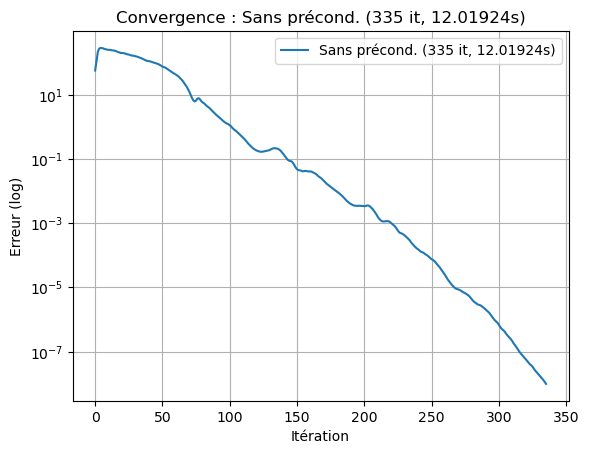

In [19]:
if __name__ == "__main__":
    n = 100
    A = generate_poisson_2d_dense(n)
    N = n * n
    b = np.random.rand(N)
    x0 = np.zeros(N)  
    
    print(">> Résolution sans préconditionneur")
    x, err, it, dur = gradient_conjugue(A, b, x0)
    print(f"Sans précond. : {it} itérations, {dur:.4f}s")
    print("Erreurs (début) :", err[:5])
    plot_single_convergence(err, f"Sans précond. ({it} it, {dur:.5f}s)")
    

# Résolution avec préconditionneur Jacobi

>> Résolution avec préconditionneur Jacobi
Jacobi : 335 itérations, 12.2052s
Erreurs (début) : [57.25836974508314, 109.92277369454794, 218.56055346143808, 275.2268988404765, 289.5772305932317]


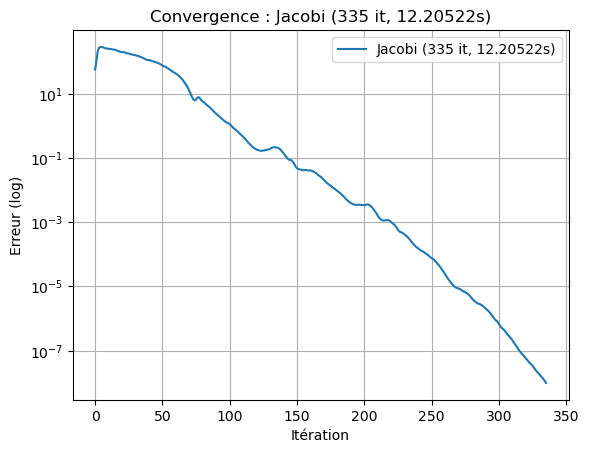

In [21]:
   
    print(">> Résolution avec préconditionneur Jacobi")
    M_jacobi = jacobi_preconditioner(A)
    x_jacobi, err_jacobi, it_jacobi, dur_jacobi = gradient_conjugue(A, b, x0, M=M_jacobi)
    print(f"Jacobi : {it_jacobi} itérations, {dur_jacobi:.4f}s")
    print("Erreurs (début) :", err_jacobi[:5])
    plot_single_convergence(err_jacobi, f"Jacobi ({it_jacobi} it, {dur_jacobi:.5f}s)")
   

>> Résolution avec préconditionneur SSOR
SSOR : 135 itérations, 136.5240s
Erreurs (début) : [57.25836974508314, 264.9448942902563, 245.14361908544504, 236.79984487898616, 232.28660178091764]


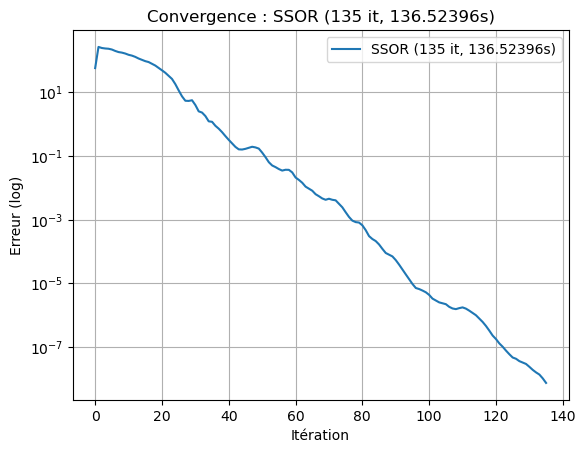

In [22]:
    print(">> Résolution avec préconditionneur SSOR")
    M_ssor = ssor_preconditioner(A, omega=1.0)
    x_ssor, err_ssor, it_ssor, dur_ssor = gradient_conjugue(A, b, x0, M=M_ssor)
    print(f"SSOR : {it_ssor} itérations, {dur_ssor:.4f}s")
    print("Erreurs (début) :", err_ssor[:5])
    plot_single_convergence(err_ssor, f"SSOR ({it_ssor} it, {dur_ssor:.5f}s)")
    

 # Tracé comparatif final 

Longueurs des erreurs : Sans = 336, Jacobi = 336, SSOR = 136
Égalité des erreurs sans et Jacobi ? True


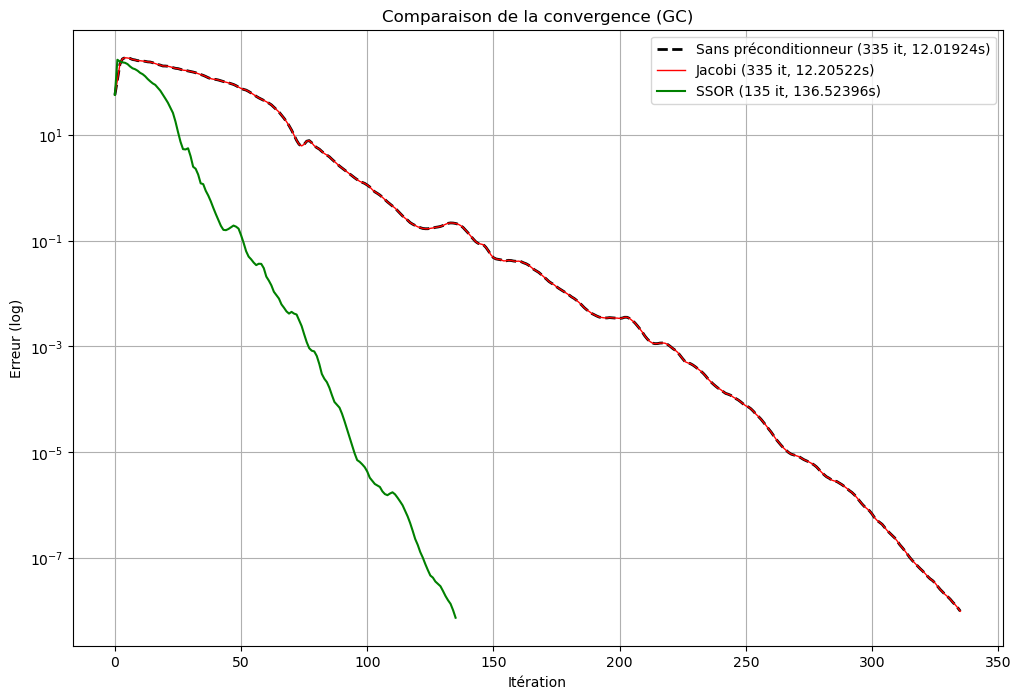

In [32]:
print(f"Longueurs des erreurs : Sans = {len(err)}, Jacobi = {len(err_jacobi)}, SSOR = {len(err_ssor)}")
print(f"Égalité des erreurs sans et Jacobi ? {np.allclose(err, err_jacobi)}")

plt.figure(figsize=(12,8))
plt.semilogy(err, label=f"Sans préconditionneur ({it} it, {dur:.5f}s)", color="black", linestyle="--", linewidth=2)
plt.semilogy(err_jacobi, label=f"Jacobi ({it_jacobi} it, {dur_jacobi:.5f}s)", color="red",linestyle="-", linewidth=1)
plt.semilogy(err_ssor, label=f"SSOR ({it_ssor} it, {dur_ssor:.5f}s)", color="green")
plt.xlabel("Itération")
plt.ylabel("Erreur (log)")
plt.title("Comparaison de la convergence (GC)")
plt.grid(True)
plt.legend()
plt.savefig('Comparaison_de_la_convergence.png')
plt.show()
